# Prisma Diagram

Here we provide a **P**referred **R**eporting **I**tems for **S**ystematic Reviews and **M**eta-**A**nalyses (PRISMA) diagram.  PRSIMA aims to improve the reporting of systematic reviews.  Full details of the PRISMA statement can be found on at [https://prisma-statement.org](https://prisma-statement.org)

The flow diagram generated visualises the manuscripts returned from multiple database searches, duplicates, titles/abstracts screened in/out; and manuscripts included excluded during full text screening.

## Overview of notebook

This notebook uses the `graphviz` library to generate a flow diagram.  It is separated into four sections: imports; a function to create the flow diagram; a script to populate a `dict` with the findings from our study; and the code to run function and save the image to file.

## Limitations

It was not possible to completely automate our deduplication process. This was part done using our own software (stripping whitespace and punctunctation), and part using Zotero to match probably duplicates and then manually merge. Our published dataset contains all papers we **attempted to retrieve**.  This means we can only calculate statistics the full test screening stage of our review.  

## 1. Imports

### 1.1 Graphviz imports

We have generated our PRSIMA diagram using `graphviz`

In [1]:
from graphviz import Digraph
from graphviz import Graph
import pydot

### 1.2 Standard imports

In [2]:
import pandas as pd
import numpy as np

### 1.3 Imports from preprocessing module

In [3]:
# function for loading full dataset
from preprocessing import load_clean_dataset

## 2. Constants

In [4]:
FILE_NAME = 'https://raw.githubusercontent.com/TomMonks/' \
    + 'des_sharing_lit_review/main/data/share_sim_data_extract.zip'

# pre-screnning file locations
POST_FIX = '../../data/pre_screening/'
POST_FIX_STAGE1 = '../../data/stage1/'
SCOPUS = POST_FIX + 'Scopus_search.zip'
PUBMED = POST_FIX + 'pubmed_part.zip'
ACM = POST_FIX + '20220903_acm.zip'
WOS = POST_FIX + '20220903_wos.zip'
UNIQUE = POST_FIX_STAGE1 + 'unique_papers.zip'

## 3. Functions to create diagram

We provide functions to calculate basic statistics for the dataset i.e.

* number_studies_included
* studies_to_retrieve
* papers_not_retrieved
* excluded_count
* models_with_code
* A number of functions to return the number of records retrieved from the databases included in the study.

And a function to create the `graphviz` based prisma diagram.

* graph_prisma

In [5]:
def number_studies_included(df):
    '''
    Return the number of studies included after screening.
    
    Params:
    ------
    df: pd.DataFrame
        The dataframe - expected to be the full study
        
    Returns:
    -------
    int
    '''
    return len(df[df['study_included'] == 1])

In [6]:
def studies_to_retrieve(df):
    '''
    Return the number of studies to retrieve after screening
    
    Params:
    ------
    df: pd.DataFrame
        The dataframe - expected to be the full study
        
    Returns:
    -------
    int
    '''
    return len(df)

In [7]:
def papers_not_retrieved(df):
    '''
    Return the number of studies not retrieved.
    These are labelled as 'Full Text Not Availabe'
    
    Params:
    ------
    df: pd.DataFrame
        The dataframe - expected to be the full study
        
    Returns:
    -------
    int
    '''
    return len(df[df['excluded_reason'] == 'Full Text Not Available'])

In [8]:
def excluded_count(df, reason):
    '''
    Return the number of studies excluded with a specific reason.
    
    Params:
    ------
    df: pd.DataFrame
        The dataframe - expected to be the full study
        
    Returns:
    -------
    int
    '''
    return len(df[df['excluded_reason'] == reason])

In [9]:
def models_with_code(df):
    '''
    Return the number of included studies that shared DES models.
    
    Params:
    ------
    df: pd.DataFrame
        The dataframe - expected to be the full study
        
    Returns:
    -------
    int
    '''
    return len(df[(df['study_included'] == 1) & 
                   (df['model_code_available'] == 1)])

In [10]:
def returned_from_scopus_after_dedup():
    '''
    Returns the number from scopus after deduplication.
    '''
    total = 0
    for yr in range(2019, 2023):
        total += len(pd.read_csv(SCOPUS[str(yr)]))
    return total

In [11]:
def returned_from_scopus_before_dedup():
    '''
    Returns the number from PubMed BEFORE deduplication.
    '''
    return len(pd.read_csv(SCOPUS))

In [12]:
def returned_from_pubmed_before_dedup():
    '''
    Returns the number from PubMed BEFORE deduplication.
    '''
    return len(pd.read_csv(PUBMED))

In [13]:
def returned_from_acm_before_dedup():
    '''
    Returns the number from ACM Digital Library BEFORE deduplication.
    '''
    return len(pd.read_csv(ACM))

In [14]:
def returned_from_wos_before_dedup():
    '''
    Returns the number from Web of Science BEFORE deduplication.
    '''
    return len(pd.read_csv(WOS))

In [15]:
def returned_unique_papers():
    '''
    Returns the number from unique papers after dedup
    '''
    return len(pd.read_csv(UNIQUE))

In [16]:
def graph_prisma(data, filename='prisma.dot'):
    '''
    Create PRISMA flow diagram for literature review

    The output is saved in a dot format file.

    Params:
    -------
    data: dict
      Dictionary of data items
      
    Returns:
    --------
    Diagraph

    '''
    g = Digraph('G', filename=filename)

    #g.attr(label=r"\n\nPrisma Flow Diagram")
    g.attr(fontsize='14')

    node1_txt = f"Records identified from: \nScopus " \
        + f"(n = {str(data['scopus_n'])}) \nPubMed " \
        + f"(n = {str(data['pubmed_n'])}) \nACM " \
        + f"(n = {str(data['acm_n'])}) \nWoS " \
        + f"(n = {str(data['wos_n'])})"
    node1 = g.node('A', node1_txt, shape='rectangle')

    node2_txt = f"Records removed before screening:\n" \
        + f"duplicates (n = {str(data['n_duplicates'])})"
    node2 = g.node('B', node2_txt, shape='rectangle')

    node3_txt = f"Records screened\n (n = {str(data['n_title_abstract'])})"
    node3 = g.node('C', node3_txt, shape='rectangle')

    node4_txt = f"Records excluded\n " \
        + f"(n = {str(data['n_abstracts_excluded'])})"
    node4 = g.node('D', node4_txt, shape='rectangle')

    node5_txt = f"Papers sought for retrieval\n " \
        + f"(n = {str(data['n_to_retrieve'])})"
    node5 = g.node('E', node5_txt, shape='rectangle')

    node6_txt = f"Papers not retrieved\n (n = {str(data['n_not_retrieved'])})"
    node6 = g.node('F', node6_txt, shape='rectangle')

    node6_txt = f"Papers assessed for eligibility\n" \
        + f"(n = {str(data['n_assessed'])})"
    node6 = g.node('G', node6_txt, shape='rectangle')

    node7_txt = f"Studies included in review\n(n = {str(data['n_included'])})"
    node7 = g.node('H', node7_txt, shape='rectangle')

    # excluded reasons
    node7_txt = f"Studies excluded:\n" \
        + f"{data['exclude_reason1']} (n = {str(data['n_exclude_reason1'])})\n"\
        + f"{data['exclude_reason2']} (n = {str(data['n_exclude_reason2'])})\n"\
        + f"{data['exclude_reason3']} (n = {str(data['n_exclude_reason3'])})"
    node7 = g.node('I', node7_txt, shape='rectangle')

    g.edges(['AB', 'AC', 'CD', 'CE', 'EF', 'EG', 'GH', 'GI'])


    # subnodes for real world decisions in same graph
    snode1_txt = f"Available models\n n = {str(data['available_models_n'])}" 
    snode1 = g.node('H0', snode1_txt)

    snode2_txt = f"Included studies \n n = {str(data['n_included'])}"
    snode2 = g.node('H1', snode2_txt)

    snode3_txt = f"Percentage of models shared \n {str(data['percent'])}"
    snode3 = g.node('H2', snode3_txt)

    with g.subgraph(name='cluster_1') as c:
        c.attr(color='blue')
        c.node_attr['style'] = 'filled'
        c.edges([('H0', 'H2'), ('H1', 'H2')])
        c.attr(label="Interim results")

    g.save(filename)
    return g

## 4. Read in data

In [17]:
clean = load_clean_dataset(FILE_NAME)

## 3. Diagram Data Input
The constant below represent values obtained from searching Scopus and Pubmed and cannot be generated from our dataset.

In [18]:
# totals by database
N_SCOPUS = returned_from_scopus_before_dedup()
N_PUBMED = returned_from_pubmed_before_dedup()
N_ACM = returned_from_acm_before_dedup()
N_WOS = returned_from_wos_before_dedup()
N_TOTAL = N_SCOPUS + N_PUBMED + N_ACM + N_WOS 

# no. unique papers after semi-automated dedup
N_UNIQUE = returned_unique_papers()

# no. duplicates removed.
DUPLICATES_REMOVED = N_TOTAL - N_UNIQUE

# total abstracts/titles to sceen in stage 1
N_TITLE_ABSTRACTS = N_UNIQUE

# number excluded by stage 1 screening process
N_ABSTRACTS_EXCLUDED = N_UNIQUE - studies_to_retrieve(clean) 

# reasons for exclusion in stage 2 (excluding not able to retrieve)
EXCLUDED_REASON_1 = "Not English"
EXCLUDED_REASON_2 = "Not DES"
EXCLUDED_REASON_3 = "Not Health"

In [19]:
#  script for prisma
data = {}
data['scopus_n'] = N_SCOPUS
data['pubmed_n'] = N_PUBMED
data['acm_n'] = N_ACM
data['wos_n'] = N_WOS
data['unique_n'] = N_UNIQUE
data['n_duplicates'] = DUPLICATES_REMOVED
data['n_title_abstract'] = N_TITLE_ABSTRACTS
data['n_abstracts_excluded'] = N_ABSTRACTS_EXCLUDED
data['n_to_retrieve'] = studies_to_retrieve(clean)
data['n_not_retrieved'] = papers_not_retrieved(clean)
data['n_assessed'] = studies_to_retrieve(clean) - papers_not_retrieved(clean)
data['n_included'] = number_studies_included(clean)
data['exclude_reason1'] = EXCLUDED_REASON_1
data['exclude_reason2'] = EXCLUDED_REASON_2
data['exclude_reason3'] = EXCLUDED_REASON_3
data['n_exclude_reason1'] = excluded_count(clean, EXCLUDED_REASON_1)
data['n_exclude_reason2'] = excluded_count(clean, EXCLUDED_REASON_2)
data['n_exclude_reason3'] = excluded_count(clean, EXCLUDED_REASON_3)
data['available_models_n'] = models_with_code(clean)
data['percent'] = round((models_with_code(clean) / \
                         number_studies_included(clean)) \
                        * 100, 1)

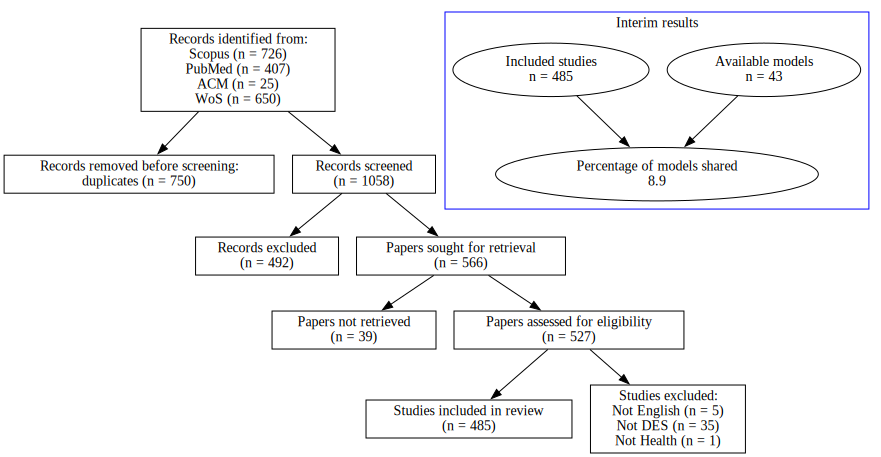

In [20]:
g = graph_prisma(data)
g

In [21]:
# save to file
(graph,) = pydot.graph_from_dot_file('prisma.dot')
graph.set_dpi(300)
graph.write_png('prisma.png')